In [13]:
import feedparser
import requests
import re
import pandas as pd
import time
import smtplib
from email.mime.text import MIMEText
from typing import List, Dict, Any
import os
import json
import numpy as np

# --- CONFIGURATION ---
ANSSI_FEEDS = [
    ("Avis", "https://www.cert.ssi.gouv.fr/avis/feed/"),
    ("Alerte", "https://www.cert.ssi.gouv.fr/alerte/feed/")
]
RATE_LIMIT_SECONDS = 2
CSV_OUTPUT = "consolidated_anssi_cve.csv"

# Étape 5 : Interprétation et Visualisation des Vulnérabilités

Nous allons utiliser le DataFrame `df` déjà présent en mémoire pour explorer et visualiser les vulnérabilités.

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
# df doit déjà être défini dans l'environnement
import pandas as pd
df = pd.read_csv('consolidated_anssi_cve.csv', dtype=str)

df['Type_encoded'] = df['Type'].map({'Avis': 0, 'Alerte': 1})
df.head(5)

,ID ANSSI,Titre ANSSI,Type,Date,CVE,CVSS,Base Severity,CWE,CWE Description,EPSS,Lien,Description,Éditeur,Produit,Versions affectées,Type_encoded
0,CERTFR-2025-AVI-0392,Multiples vulnérabilités dans Mattermost Serve...,Avis,"Tue, 13 May 2025 00:00:00 +0000",CVE-2025-4128,3.1,LOW,CWE-863,CWE-863: Incorrect Authorization,0.00023,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,"Mattermost versions 10.5.x <= 10.5.4, 9.11.x <...",Mattermost,Mattermost,"10.5.0, 9.11.0",0
1,CERTFR-2025-AVI-0392,Multiples vulnérabilités dans Mattermost Serve...,Avis,"Tue, 13 May 2025 00:00:00 +0000",CVE-2025-4573,4.1,MEDIUM,CWE-90,CWE-90: Improper Neutralization of Special Ele...,0.00028,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,"Mattermost versions 10.7.x <= 10.7.1, 10.6.x <...",Mattermost,Mattermost,"10.7.0, 10.6.0, 10.5.0, 9.11.0",0
2,CERTFR-2025-AVI-0396,Multiples vulnérabilités dans les produits SAP...,Avis,"Tue, 13 May 2025 00:00:00 +0000",CVE-2025-43003,6.4,MEDIUM,CWE-749,CWE-749: Exposed Dangerous Method or Function,0.00053,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,SAP S/4 HANA allows an authenticated attacker ...,SAP_SE,SAP S/4HANA (Private Cloud & On-Premise),"S4CRM 204, 205, 206, S4CEXT 107, 108, BBPCRM 7...",0
3,CERTFR-2025-AVI-0396,Multiples vulnérabilités dans les produits SAP...,Avis,"Tue, 13 May 2025 00:00:00 +0000",CVE-2025-43007,6.3,MEDIUM,CWE-862,CWE-862: Missing Authorization,0.00044,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,SAP Service Parts Management (SPM) does not pe...,SAP_SE,SAP Service Parts Management (SPM),"SAP_APPL 617, 618, S4CORE 100, 101, 102, 103",0
4,CERTFR-2025-AVI-0396,Multiples vulnérabilités dans les produits SAP...,Avis,"Tue, 13 May 2025 00:00:00 +0000",CVE-2025-23191,3.1,LOW,CWE-644,CWE-644: Improper Neutralization of HTTP Heade...,0.0005,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,Cached values belonging to the SAP OData endpo...,SAP_SE,SAP Fiori for SAP ERP,"SAP_GWFND 740, 750, 751, 752, 753, 754, 755, 7...",0


## 1. Histogramme des scores CVSS

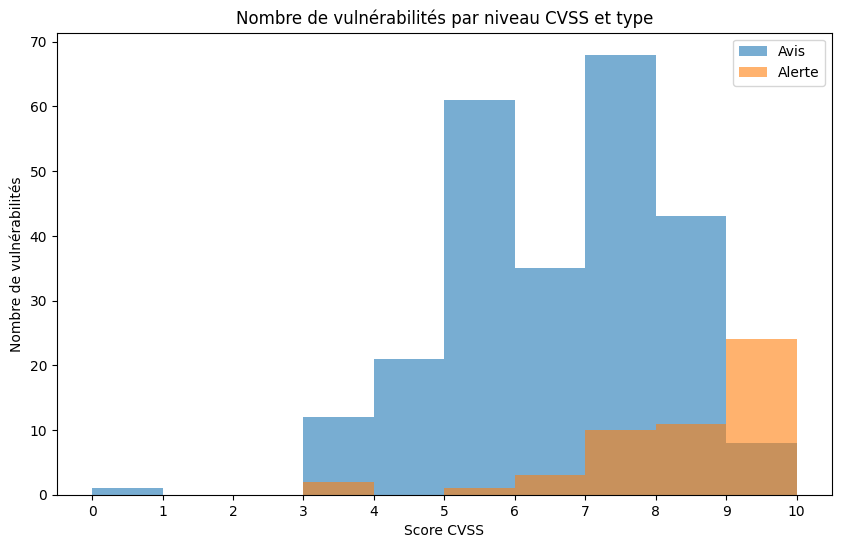

In [16]:
# Histogramme du nombre de vulnérabilités par niveau CVSS et par type (type_encoded)
plt.figure(figsize=(10,6))
bins = range(0, 11)  # CVSS de 0 à 10

# Convertir la colonne CVSS en float pour éviter les erreurs de type
df['CVSS'] = pd.to_numeric(df['CVSS'], errors='coerce')

for tval, label in zip([0, 1], ['Avis', 'Alerte']):
    subset = df[df['Type_encoded'] == tval]
    plt.hist(subset['CVSS'].dropna(), bins=bins, alpha=0.6, label=label)
plt.title('Nombre de vulnérabilités par niveau CVSS et type')
plt.xlabel('Score CVSS')
plt.ylabel('Nombre de vulnérabilités')
plt.legend()
plt.xticks(bins)
plt.show()

## 2. Diagramme circulaire des types de vulnérabilités (CWE)

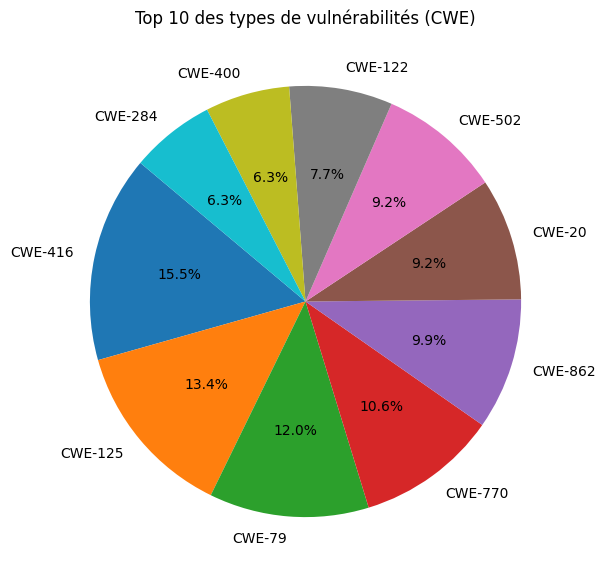

In [17]:
# Utiliser uniquement les lignes où 'cwe' existe, n'est pas NaN, et n'est pas "Non disponible"
df_temp = df.copy()
df_cwe = df_temp[df_temp['CWE'].notna() & (df_temp['CWE'] != '') & (df_temp['CWE'] != 'Non disponible')]
cwe_counts = df_cwe['CWE'].value_counts().head(10)
plt.figure(figsize=(7,7))
plt.pie(cwe_counts, labels=cwe_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 des types de vulnérabilités (CWE)')
plt.show()

## 3. Courbe des scores EPSS (logarithmique)

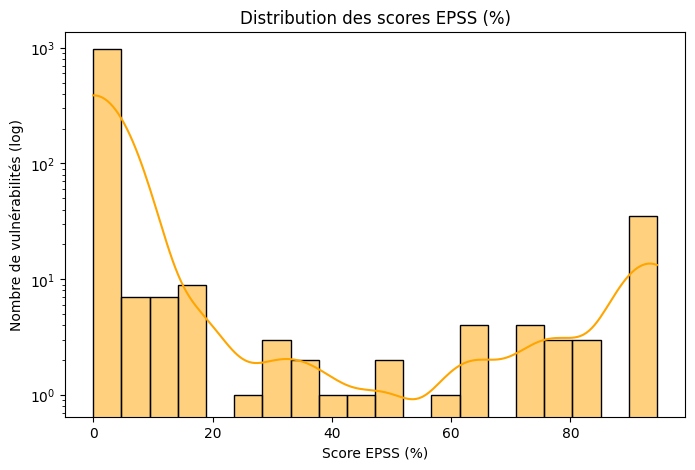

In [18]:
# Afficher la distribution des scores EPSS en pourcentage (0 à 100%) avec une échelle logarithmique sur l'axe Y
epss_percent = df['EPSS'].dropna().astype(float) * 100
plt.figure(figsize=(8,5))
sns.histplot(epss_percent, bins=20, kde=True, color='orange')
plt.yscale('log')
plt.title('Distribution des scores EPSS (%)')
plt.xlabel('Score EPSS (%)')
plt.ylabel('Nombre de vulnérabilités (log)')
plt.show()

## 4. Classement des produits les plus affectés

C:\Users\maxim\AppData\Local\Temp\ipykernel_21044\3858725932.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_Produits_df, x='count', y='Produit', palette='viridis')


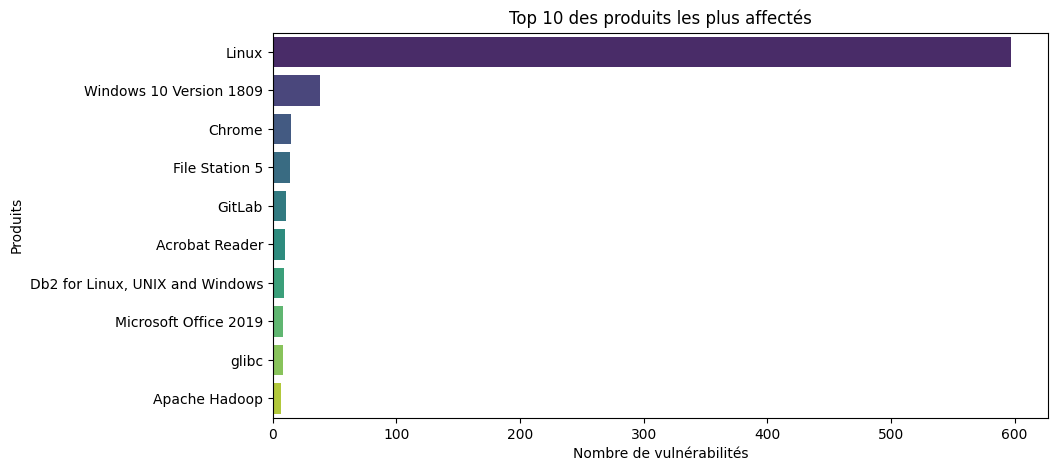

In [19]:
df_Produits = df.copy()
df_Produits = df_Produits.explode('Produit')
df_Produits = df_Produits[df_Produits['Produit'].notna() & (df_Produits['Produit'] != '') & (df_Produits['Produit'] != 'n/a')]

top_Produits = df_Produits['Produit'].value_counts().head(10)
top_Produits_df = top_Produits.reset_index()
top_Produits_df.columns = ['Produit', 'count']

plt.figure(figsize=(10,5))
sns.barplot(data=top_Produits_df, x='count', y='Produit', palette='viridis')
plt.title('Top 10 des produits les plus affectés')
plt.xlabel('Nombre de vulnérabilités')
plt.ylabel('Produits')
plt.show()



## 5. Nuage de points entre Score CVSS et Score EPSS

Corrélation linéaire CVSS / EPSS : 0.427


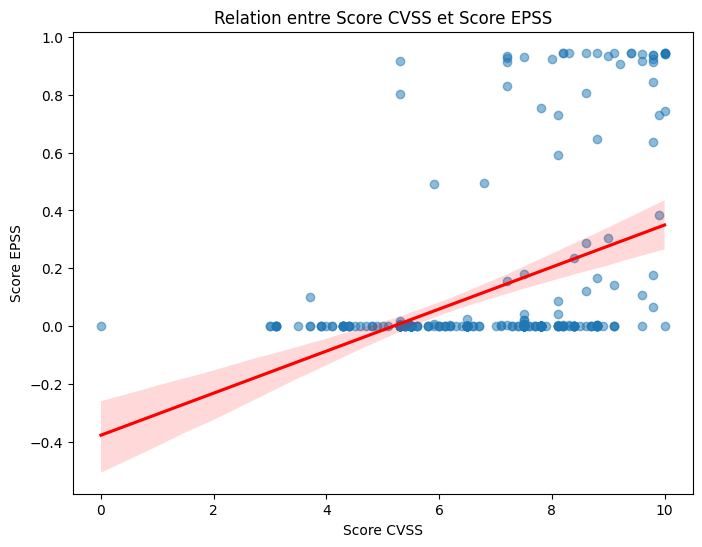

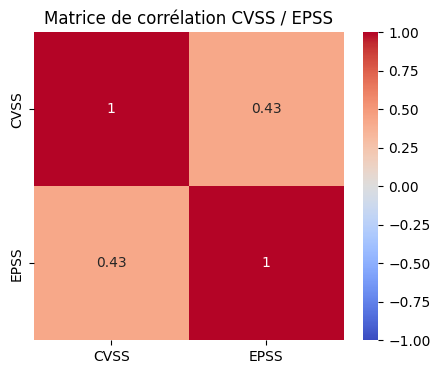

In [20]:
# Analyse de l'impact du score CVSS sur le score EPSS

# Nettoyer les données pour ne garder que les lignes avec CVSS, EPSS et severity valides
df_corr = df[['CVSS', 'EPSS', 'Base Severity']].dropna().copy()
df_corr['CVSS'] = df_corr['CVSS'].astype(float)
df_corr['EPSS'] = df_corr['EPSS'].astype(float)

# 1. Afficher la corrélation linéaire
correlation = df_corr['CVSS'].corr(df_corr['EPSS'])
print(f"Corrélation linéaire CVSS / EPSS : {correlation:.3f}")

# 2. Visualiser la relation par un scatterplot avec régression
plt.figure(figsize=(8,6))
sns.regplot(data=df_corr, x='CVSS', y='EPSS', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Relation entre Score CVSS et Score EPSS')
plt.xlabel('Score CVSS')
plt.ylabel('Score EPSS')
plt.show()

# 3. Matrice de corrélation complète entre toutes les variables numériques
plt.figure(figsize=(5,4))
corr_matrix = df_corr[['CVSS', 'EPSS']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matrice de corrélation CVSS / EPSS')
plt.show()

## 6. Courbe cumulative des vulnérabilités en fonction du temps (logarithmique)

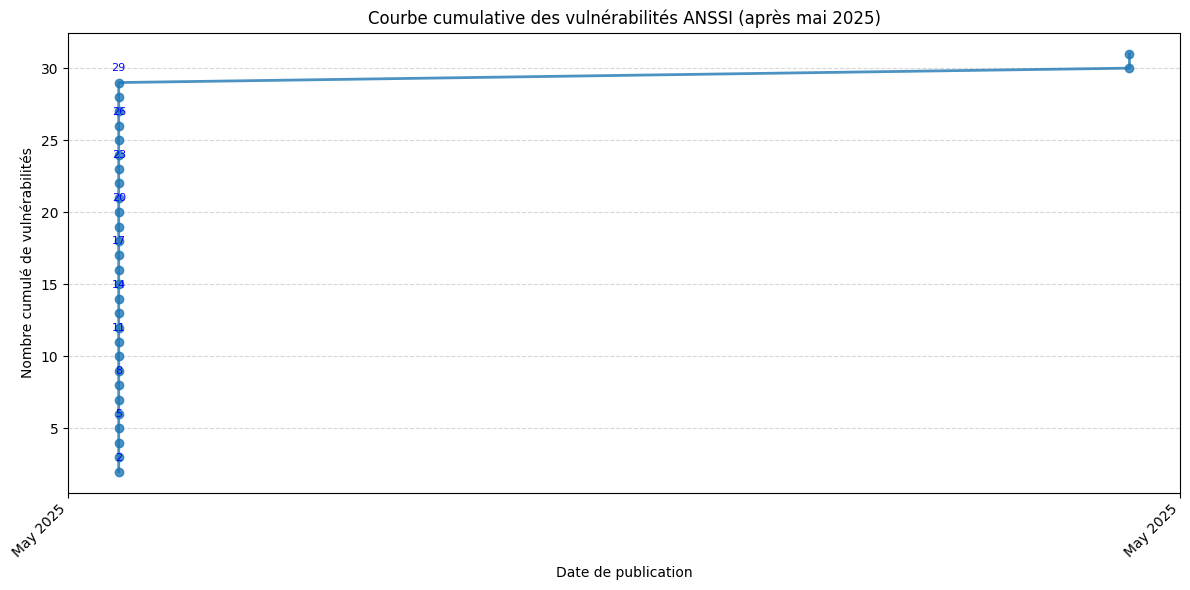

In [35]:
# Courbe cumulative des vulnérabilités dans le temps (après mai 2025 uniquement)

import matplotlib.dates as mdates

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df_sorted = df.sort_values('Date')
df_sorted = df_sorted[df_sorted['Date'].notna()]
df_sorted['cumulative'] = range(1, len(df_sorted)+1)

# S'assurer que la comparaison se fait avec des objets tz-naive
start_date = pd.Timestamp('2025-05-01')
if df_sorted['Date'].dt.tz is not None:
    # Si les dates sont tz-aware, rendre start_date aussi tz-aware
    start_date = start_date.tz_localize(df_sorted['Date'].dt.tz)
else:
    # Sinon, rendre toutes les dates tz-naive
    df_sorted['Date'] = df_sorted['Date'].dt.tz_localize(None)

df_plot = df_sorted[df_sorted['Date'] >= start_date]

plt.figure(figsize=(12,6))
plt.plot(df_plot['Date'].dt.tz_localize(None), df_plot['cumulative'], marker='o', linewidth=2, alpha=0.8)
plt.title("Courbe cumulative des vulnérabilités ANSSI (après mai 2025)")
plt.xlabel('Date de publication')
plt.ylabel('Nombre cumulé de vulnérabilités')
plt.grid(True, which='major', linestyle='--', alpha=0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.xticks(rotation=45, ha='right')

for d, c in zip(df_plot['Date'][::max(1, len(df_plot)//8)], df_plot['cumulative'][::max(1, len(df_plot)//8)]):
    plt.annotate(f"{c}", (d, c), textcoords="offset points", xytext=(0,8), ha='center', fontsize=8, color='blue')

plt.tight_layout()
plt.show()

## 7. Boxplot des scores CVSS par éditeur

In [37]:
df_vendor = df.copy()
df_vendor = df_vendor.explode('Éditeur')
df_vendor = df_vendor[df_vendor['Éditeur'].notna() & (df_vendor['Éditeur'] != '') & (df_vendor['Éditeur'] != 'n/a') & (df_vendor['Éditeur'] != 'Non disponible')]

# Supprimer les doublons après explode pour éviter de compter plusieurs fois la même vulnérabilité pour un éditeur
df_vendor = df_vendor.drop_duplicates(subset=['CVE', 'Éditeur'])

top_editors = df_vendor['Éditeur'].value_counts().head(5).index

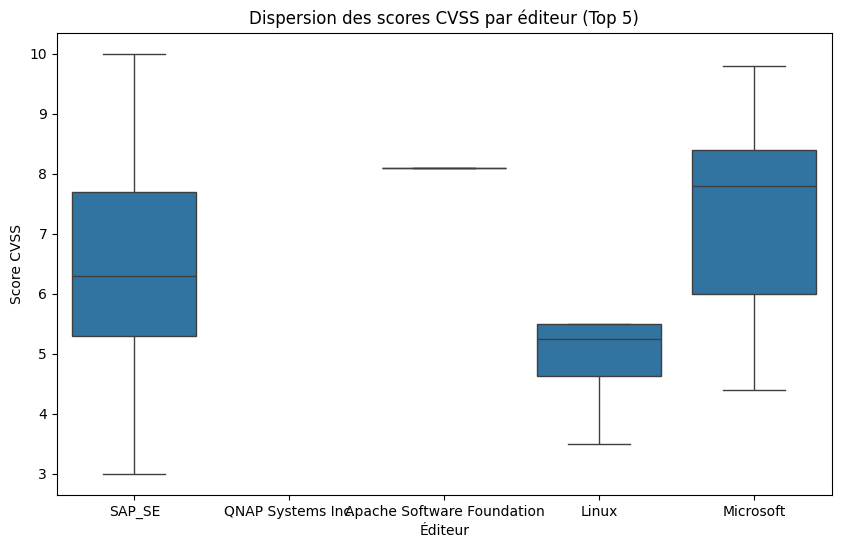

In [39]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_vendor[df_vendor['Éditeur'].isin(top_editors)], x='Éditeur', y='CVSS')
plt.title('Dispersion des scores CVSS par éditeur (Top 5)')
plt.xlabel('Éditeur')
plt.ylabel('Score CVSS')
plt.show()

linear regression to predict EPSS :

In [41]:
df_cleaned = df.dropna(subset=['CVSS', 'CVE', 'EPSS']).copy()

Régression pour prédire le score CVSS à partir des features numériques et TF-IDF :
  R2 score (test)     : -0.0493
  RMSE (test)         : 2.6757
  MAE (test)          : 1.0818


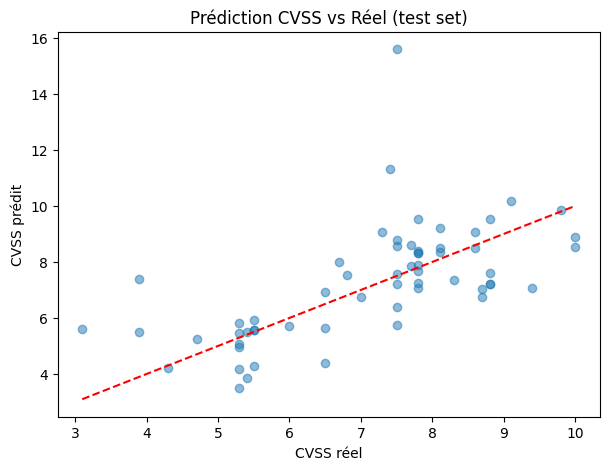

In [43]:
# Régression pour prédire le score CVSS à partir des features numériques et TF-IDF (description et titre)

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

# Utiliser les colonnes du CSV (majuscule)
df_cleaned = df.dropna(subset=['CVSS', 'CVE', 'EPSS']).copy()

# Préparation des features numériques
features = ['EPSS']
if 'Base Severity' in df_cleaned.columns:
    df_cleaned['severity_encoded'] = df_cleaned['Base Severity'].astype('category').cat.codes
    features.append('severity_encoded')

X_num = df_cleaned[features].fillna(0)

# Préparation des features textuelles (Description et Titre ANSSI)
desc = df_cleaned['Description'].fillna('')
titre = df_cleaned['Titre ANSSI'].fillna('')

# utilisation de TF-IDF pour les colonnes textuelles
tfidf_desc = TfidfVectorizer(max_features=100)
tfidf_titre = TfidfVectorizer(max_features=50)

X_desc = tfidf_desc.fit_transform(desc)
X_titre = tfidf_titre.fit_transform(titre)

# Standardiser les features numériques
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# Concaténer toutes les features (numériques + textuelles)
X_all = hstack([csr_matrix(X_num_scaled), X_desc, X_titre])

y = df_cleaned['CVSS'].astype(float)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=42)

# Modèle de régression
reg = LinearRegression()
reg.fit(X_train, y_train)

# Prédictions
y_pred = reg.predict(X_test)

# Évaluation
print("Régression pour prédire le score CVSS à partir des features numériques et TF-IDF :")
print(f"  R2 score (test)     : {r2_score(y_test, y_pred):.4f}")
print(f"  RMSE (test)         : {mean_squared_error(y_test, y_pred):.4f}")
print(f"  MAE (test)          : {mean_absolute_error(y_test, y_pred):.4f}")

# Visualisation des prédictions vs valeurs réelles
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('CVSS réel')
plt.ylabel('CVSS prédit')
plt.title('Prédiction CVSS vs Réel (test set)')
plt.show()

Répartition des vulnérabilités par cluster :
cluster
0    125
1    101
3     37
2     33
Name: count, dtype: int64


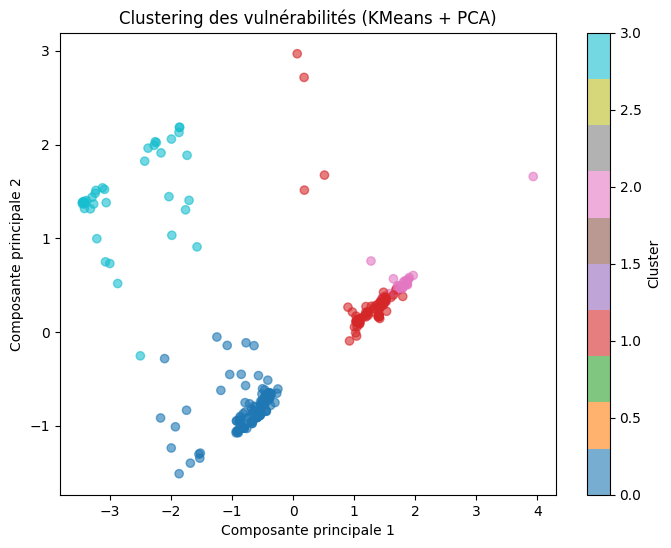

In [44]:
# Clustering des vulnérabilités avec KMeans (features : EPSS, CVSS, severity_encoded, TF-IDF Description/Titre ANSSI)

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Utiliser les colonnes du CSV (majuscule)
features = ['CVSS', 'EPSS']
if 'Base Severity' in df_cleaned.columns:
    df_cleaned['severity_encoded'] = df_cleaned['Base Severity'].astype('category').cat.codes
    features.append('severity_encoded')

X_num = df_cleaned[features].fillna(0)

# TF-IDF sur Description et Titre ANSSI
desc = df_cleaned['Description'].fillna('')
titre = df_cleaned['Titre ANSSI'].fillna('')

tfidf_desc = TfidfVectorizer(max_features=50)
tfidf_titre = TfidfVectorizer(max_features=30)

X_desc = tfidf_desc.fit_transform(desc)
X_titre = tfidf_titre.fit_transform(titre)

# Standardisation des features numériques
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# Concaténation des features
X_all = hstack([csr_matrix(X_num_scaled), X_desc, X_titre])

# KMeans clustering (nombre de clusters arbitraire, par exemple 4)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_all)

# Ajout du cluster au DataFrame
df_cleaned['cluster'] = clusters

# Affichage de la répartition des clusters
print("Répartition des vulnérabilités par cluster :")
print(df_cleaned['cluster'].value_counts())

# Visualisation 2D avec PCA
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X_all.toarray())

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_vis[:,0], X_vis[:,1], c=clusters, cmap='tab10', alpha=0.6)
plt.title('Clustering des vulnérabilités (KMeans + PCA)')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.colorbar(scatter, label='Cluster')
plt.show()